# Seção 04.04 -  Aprendizagem Bayesiana (base Acute Inflammations)
Para esta seção, usarei a base de dados "Acute Inflammations Data Set" disponível no UCI Machine Learning datasets (http://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

In [24]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Lidar com validação de modelos.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [2]:
nomeDaBase = "../bases/diagnosis.csv"
df = pd.read_csv(nomeDaBase, sep=";", encoding="utf-8")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
a1 Temperature of patient                                  120 non-null float64
a2 Occurrence of nausea                                    120 non-null object
a3 Lumbar pain                                             120 non-null object
a4 Urine pushing (continuous need for urination)           120 non-null object
a5 Micturition pains                                       120 non-null object
a6 Burning of urethra. itch. swelling of urethra outlet    120 non-null object
d1 Inflammation of urinary bladder                         120 non-null object
d2 Nephritis of renal pelvis origin                        120 non-null object
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


## 1) Análise preliminar dos dados:
Como é possível observar, as colunas classificamse conforme indicado abaixo:
a1 Temperature of patient - dados numéricos e contínuo
a2 Occurrence of nausea - dados binários
a3 Lumbar pain - dados binários
a4 Urine pushing (continuous need for urination) - dados binários
a5 Micturition pains - dados binários
a6 Burning of urethra. itch. swelling of urethra outlet - dados binários
d1 Inflammation of urinary bladder - dados binários
d2 Nephritis of renal pelvis origin - dados binários

As colunas designadas como d1 e d2 são as respostas ou alvos, enquanto as colunas designadas como a1 a a6 são os fatores ou previsores. 

In [4]:
x_categoricas = df.iloc[:,1:6]
y_categoricas = df.iloc[:,6:]
x_categoricas.head()

,a2 Occurrence of nausea,a3 Lumbar pain,a4 Urine pushing (continuous need for urination),a5 Micturition pains,a6 Burning of urethra. itch. swelling of urethra outlet
0,no,yes,no,no,no
1,no,no,yes,yes,yes
2,no,yes,no,no,no
3,no,no,yes,yes,yes
4,no,yes,no,no,no


In [5]:
y_categoricas.head()

,d1 Inflammation of urinary bladder,d2 Nephritis of renal pelvis origin
0,no,no
1,yes,no
2,no,no
3,yes,no
4,no,no


Para adequar os dados para o modelo de aprendizagem Bayesiana, trocarei os dados "yes" e "no" por "1" e "0", respectivamente. Caso tivéssemos mais nuances, uma boa alterntiva seria usar o métodos *pd.get_dummies*.

In [6]:
x_categoricas = x_categoricas.replace(["no","yes"],[0,1])
y_categoricas = y_categoricas.replace(["no","yes"],[0,1])

In [7]:
x_categoricas.head()

,a2 Occurrence of nausea,a3 Lumbar pain,a4 Urine pushing (continuous need for urination),a5 Micturition pains,a6 Burning of urethra. itch. swelling of urethra outlet
0,0,1,0,0,0
1,0,0,1,1,1
2,0,1,0,0,0
3,0,0,1,1,1
4,0,1,0,0,0


In [8]:
y_categoricas.head()

,d1 Inflammation of urinary bladder,d2 Nephritis of renal pelvis origin
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0


In [9]:
df_preparada = pd.concat([df.iloc[:,:1],x_categoricas, y_categoricas],axis=1)

Por fim, temos o dataframe pronto para aplicar o modelo:

In [10]:
df_preparada.head(10).T

,0,1,2,3,4,5,6,7,8,9
a1 Temperature of patient,35.5,35.9,35.9,36.0,36.0,36.0,36.2,36.2,36.3,36.6
a2 Occurrence of nausea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a3 Lumbar pain,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
a4 Urine pushing (continuous need for urination),0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
a5 Micturition pains,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
a6 Burning of urethra. itch. swelling of urethra outlet,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
d1 Inflammation of urinary bladder,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
d2 Nephritis of renal pelvis origin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2) Separação do dataset em treino, validação e teste.
Como temos somente um dataset, vamos separá-lo primeiramente em três partes:

    1- Treino;
    2- Validação; e
    3- Teste.
    
Porém, vamos usar o método *sklearn.model_selection.train_test_split* 2 vezes para obtermos essa separação.

In [11]:
x = df_preparada.iloc[:,0:6]
y = df_preparada.iloc[:,6:]

# Aqui abaixo, normatiza-se (ou escalona-se) os fatores/previsores.
scaler = StandardScaler()
x = scaler.fit_transform(x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 3) Aplicando o modelo de aprendizagem Bayesiana

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
classificador = GaussianNB()
classificador.fit(x_train, y_train["d1 Inflammation of urinary bladder"])

GaussianNB(priors=None, var_smoothing=1e-09)

In [15]:
y_pred = classificador.predict(x_test)

### Verificando o como o modelo se saiu

In [16]:
print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test["d1 Inflammation of urinary bladder"], y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test["d1 Inflammation of urinary bladder"], y_pred)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    confusion_matrix(y_test["d1 Inflammation of urinary bladder"], y_pred)))

Métrica 1 (Acurácia): 0.791667.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.71      1.00      0.83        12

   micro avg       0.79      0.79      0.79        24
   macro avg       0.85      0.79      0.78        24
weighted avg       0.85      0.79      0.78        24
.
Métrica 2 (Relatório de classificação):
[[ 7  5]
 [ 0 12]].


Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.         1.        ]]


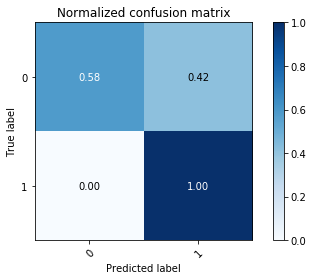

In [17]:
plot_confusion_matrix_2(y_test["d1 Inflammation of urinary bladder"], y_pred, normalize=True);

In [25]:
roc_curve(y_test["d1 Inflammation of urinary bladder"], y_pred)

(array([0.  , 0.25, 1.  ]),
 array([0.  , 0.25, 1.  ]),
 array([2, 1, 0], dtype=int64))

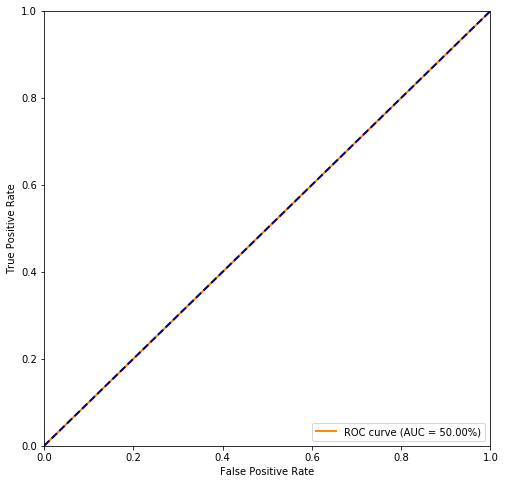

0.5

In [26]:
plot_roc(y_test["d1 Inflammation of urinary bladder"], y_pred)

### Classificando novamente, mas para a segunda resposta (y_train["d2 Nephritis of renal pelvis origin"])

In [18]:
classificador = GaussianNB()
classificador.fit(x_train, y_train["d2 Nephritis of renal pelvis origin"])

GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
y_pred = classificador.predict(x_test)

In [20]:
print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test["d2 Nephritis of renal pelvis origin"], y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test["d2 Nephritis of renal pelvis origin"], y_pred)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    confusion_matrix(y_test["d2 Nephritis of renal pelvis origin"], y_pred)))

Métrica 1 (Acurácia): 0.875.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.67      0.80         9

   micro avg       0.88      0.88      0.88        24
   macro avg       0.92      0.83      0.85        24
weighted avg       0.90      0.88      0.87        24
.
Métrica 2 (Relatório de classificação):
[[15  0]
 [ 3  6]].


Normalized confusion matrix
[[1.         0.        ]
 [0.33333333 0.66666667]]


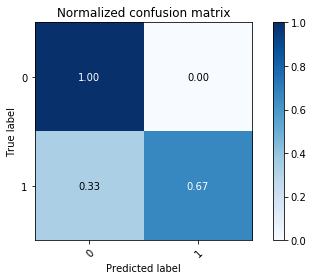

In [21]:
plot_confusion_matrix_2(y_test["d2 Nephritis of renal pelvis origin"], y_pred, normalize=True);

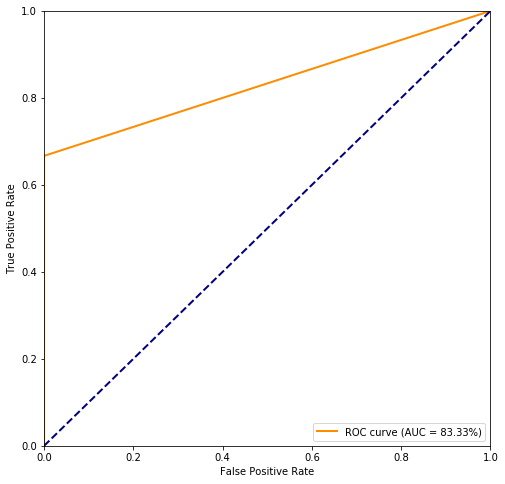

0.8333333333333333

In [27]:
plot_roc(y_test["d2 Nephritis of renal pelvis origin"], y_pred)

### Agora, usando validação cruzada.

In [22]:
classificador = GaussianNB()
classificador.fit(x, y["d1 Inflammation of urinary bladder"])

resultados = cross_val_score(classificador, x, y["d1 Inflammation of urinary bladder"], cv = 10)
print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

Acurácia média: 0.822 ± 0.163.


In [44]:
classificador = GaussianNB()
classificador.fit(x, y["d2 Nephritis of renal pelvis origin"])

resultados = cross_val_score(classificador, x, y["d2 Nephritis of renal pelvis origin"], cv = 10)
print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

Acurácia média: 0.95 ± 0.125.
